# Fine-tuning BERT-Uncased for Emotion Detection

This notebook implements a complete pipeline for fine-tuning `bert-base-uncased` on a 20-class emotion detection dataset. The key design choices are:

- **Head+Tail Truncation**: For texts exceeding 512 tokens, we keep the first 128 and last 382 tokens to preserve both the opening context and concluding sentiment.
- **Selective Layer Unfreezing**: Only BERT encoder layer 11 and the classification head are trained, keeping all other layers frozen to prevent catastrophic forgetting.
- **Low Learning Rate**: A learning rate of 2e-5 is used with AdamW for stable fine-tuning.
- **Pure PyTorch**: The entire training loop is implemented in raw PyTorch without the HuggingFace Trainer.

## 1. Setup and Imports

In [1]:
import os
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

warnings.filterwarnings("ignore")

# Reproducibility
SEED = 69
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

2026-02-15 07:20:31.230426: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771140031.536550      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771140031.646855      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771140032.475567      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771140032.475615      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771140032.475618      55 computation_placer.cc:177] computation placer alr

Using device: cuda


## 2. Data Loading

In [2]:
ds = load_dataset("shreyaspullehf/emotion_dataset_100k")
print(ds)

README.md:   0%|          | 0.00/711 [00:00<?, ?B/s]

emotion_dataset_100k.csv:   0%|          | 0.00/19.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/99746 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'emotion'],
        num_rows: 99746
    })
})


In [3]:
# Convert to a single DataFrame for EDA
# The dataset may have a single 'train' split; handle both cases
if "train" in ds and "test" in ds:
    df_train = ds["train"].to_pandas()
    df_test = ds["test"].to_pandas()
    df = pd.concat([df_train, df_test], ignore_index=True)
else:
    split_name = list(ds.keys())[0]
    df = ds[split_name].to_pandas()

print(f"Total samples: {len(df)}")
print(f"Columns: {list(df.columns)}")
df.head(10)

Total samples: 99746
Columns: ['sentence', 'emotion']


,sentence,emotion
0,"Ugh, how can something that's been sitting out...",disgust
1,"Ugh, get it off me, get it away from me, what ...",disgust
2,The thought of eating that congealed leftover ...,disgust
3,A sour taste spreads through my mouth like a s...,disgust
4,It felt like someone had dumped a bucket of ro...,disgust
5,The slimy green stuff oozing out of the broken...,disgust
6,A film of oily grime seemed to coat her skin a...,disgust
7,As I watched the monarch butterfly emerge from...,disgust
8,Disgust crept in like a shelf of tattered gran...,disgust
9,As she scrubbed the last remnants of last nigh...,disgust


### Identify text and label columns

We auto-detect the text and label columns from the dataset schema.

In [4]:
# Auto-detect column names
text_col = None
label_col = None

for col in df.columns:
    if col.lower() in ["text", "sentence", "content"]:
        text_col = col
    elif col.lower() in ["label", "emotion", "class", "labels"]:
        label_col = col

# Fallback: assume first column is text, second is label
if text_col is None:
    text_col = df.columns[0]
if label_col is None:
    label_col = df.columns[1]

print(f"Text column: '{text_col}'")
print(f"Label column: '{label_col}'")

Text column: 'sentence'
Label column: 'emotion'


## 3. Exploratory Data Analysis

### 3.1 Basic Statistics

In [5]:
print(f"Dataset shape: {df.shape}")
print(f"Number of unique labels: {df[label_col].nunique()}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nDuplicate rows: {df.duplicated().sum()}")

df[text_col] = df[text_col].astype(str)
df["char_length"] = df[text_col].apply(len)
df["word_count"] = df[text_col].apply(lambda x: len(x.split()))

print(f"\nCharacter length stats:\n{df['char_length'].describe()}")
print(f"\nWord count stats:\n{df['word_count'].describe()}")

Dataset shape: (99746, 2)
Number of unique labels: 10

Missing values:
sentence    0
emotion     0
dtype: int64

Duplicate rows: 0

Character length stats:
count    99746.000000
mean       180.231348
std         60.324853
min         12.000000
25%        142.000000
50%        171.000000
75%        205.000000
max        635.000000
Name: char_length, dtype: float64

Word count stats:
count    99746.000000
mean        31.786839
std         10.568041
min          2.000000
25%         25.000000
50%         30.000000
75%         36.000000
max         93.000000
Name: word_count, dtype: float64


### 3.2 Label Distribution

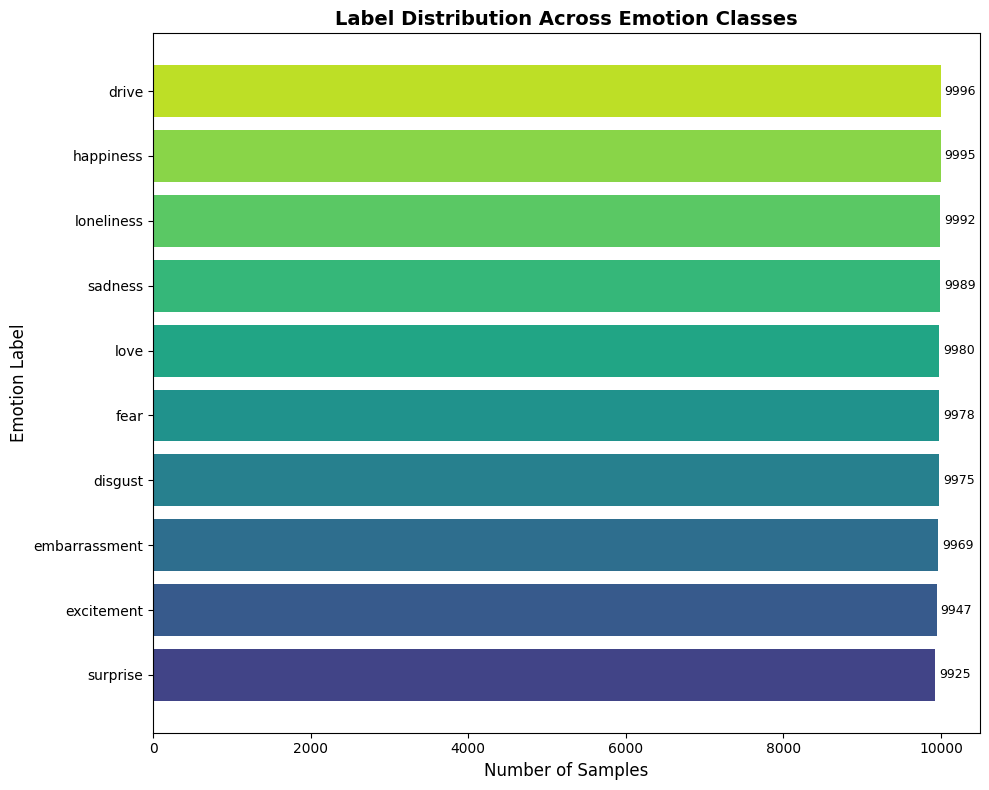


Label counts:
emotion
drive            9996
happiness        9995
loneliness       9992
sadness          9989
love             9980
fear             9978
disgust          9975
embarrassment    9969
excitement       9947
surprise         9925
Name: count, dtype: int64

Imbalance ratio (max/min): 1.01


In [6]:
label_counts = df[label_col].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(label_counts.index, label_counts.values, color=plt.cm.viridis(np.linspace(0.2, 0.9, len(label_counts))))
ax.set_xlabel("Number of Samples", fontsize=12)
ax.set_ylabel("Emotion Label", fontsize=12)
ax.set_title("Label Distribution Across Emotion Classes", fontsize=14, fontweight="bold")

for bar, count in zip(bars, label_counts.values):
    ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height() / 2, str(count),
            va="center", fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nLabel counts:\n{label_counts.sort_values(ascending=False)}")
print(f"\nImbalance ratio (max/min): {label_counts.max() / label_counts.min():.2f}")

### 3.3 Text Length Distribution

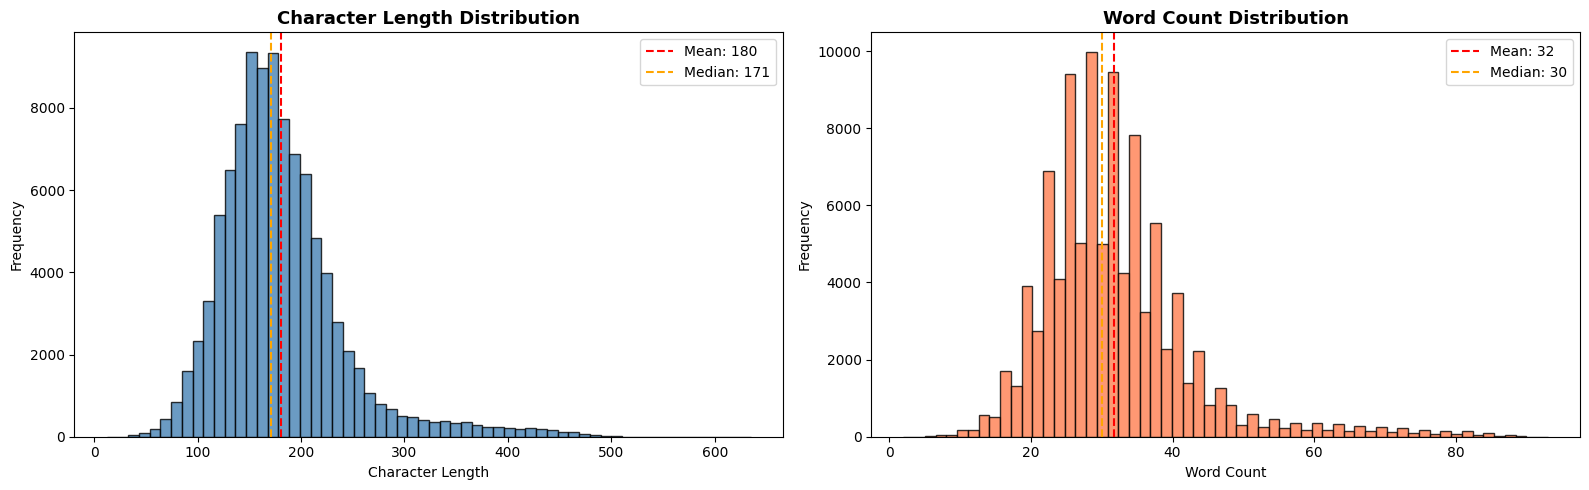

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Character length distribution
axes[0].hist(df["char_length"], bins=60, color="steelblue", edgecolor="black", alpha=0.8)
axes[0].axvline(df["char_length"].mean(), color="red", linestyle="--", label=f"Mean: {df['char_length'].mean():.0f}")
axes[0].axvline(df["char_length"].median(), color="orange", linestyle="--", label=f"Median: {df['char_length'].median():.0f}")
axes[0].set_title("Character Length Distribution", fontsize=13, fontweight="bold")
axes[0].set_xlabel("Character Length")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Word count distribution
axes[1].hist(df["word_count"], bins=60, color="coral", edgecolor="black", alpha=0.8)
axes[1].axvline(df["word_count"].mean(), color="red", linestyle="--", label=f"Mean: {df['word_count'].mean():.0f}")
axes[1].axvline(df["word_count"].median(), color="orange", linestyle="--", label=f"Median: {df['word_count'].median():.0f}")
axes[1].set_title("Word Count Distribution", fontsize=13, fontweight="bold")
axes[1].set_xlabel("Word Count")
axes[1].set_ylabel("Frequency")
axes[1].legend()

plt.tight_layout()
plt.show()

### 3.4 Token Length Distribution (BERT Tokenizer)

This is critical because BERT has a 512-token limit. We check how many samples exceed this threshold and would trigger our head+tail truncation strategy.

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Token length stats (sampled 5000 texts):
  Mean:   41.0
  Median: 39.0
  Max:    134
  Min:    11
  Texts exceeding 512 tokens: 0 (0.00%)


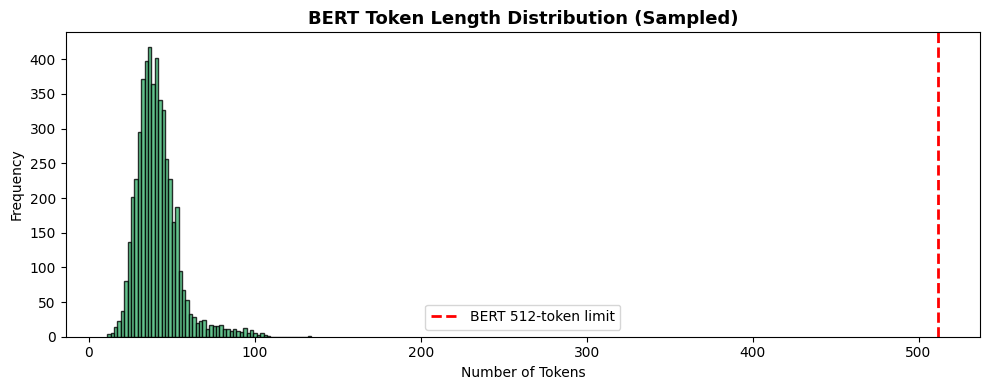

In [8]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize a sample to understand token lengths
sample_size = min(5000, len(df))
sample_texts = df[text_col].sample(n=sample_size, random_state=SEED).tolist()
token_lengths = [len(tokenizer.encode(text, add_special_tokens=True)) for text in sample_texts]

print(f"Token length stats (sampled {sample_size} texts):")
print(f"  Mean:   {np.mean(token_lengths):.1f}")
print(f"  Median: {np.median(token_lengths):.1f}")
print(f"  Max:    {np.max(token_lengths)}")
print(f"  Min:    {np.min(token_lengths)}")
print(f"  Texts exceeding 512 tokens: {sum(1 for t in token_lengths if t > 512)} ({sum(1 for t in token_lengths if t > 512) / len(token_lengths) * 100:.2f}%)")

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(token_lengths, bins=60, color="mediumseagreen", edgecolor="black", alpha=0.8)
ax.axvline(512, color="red", linestyle="--", linewidth=2, label="BERT 512-token limit")
ax.set_title("BERT Token Length Distribution (Sampled)", fontsize=13, fontweight="bold")
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Frequency")
ax.legend()
plt.tight_layout()
plt.show()

### 3.5 Text Length by Emotion Class

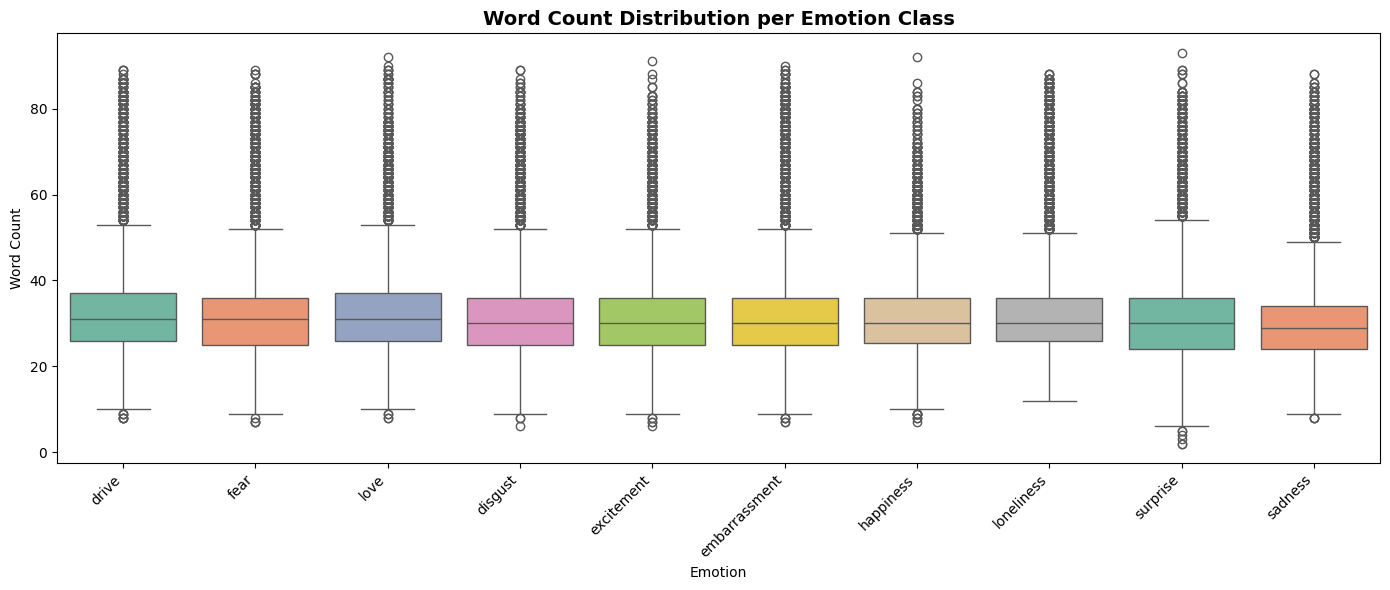

In [9]:
fig, ax = plt.subplots(figsize=(14, 6))
order = df.groupby(label_col)["word_count"].median().sort_values(ascending=False).index
sns.boxplot(data=df, x=label_col, y="word_count", order=order, ax=ax, palette="Set2")
ax.set_title("Word Count Distribution per Emotion Class", fontsize=14, fontweight="bold")
ax.set_xlabel("Emotion")
ax.set_ylabel("Word Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 4. Data Preprocessing

### 4.1 Label Encoding

In [10]:
# Build label mappings
unique_labels = sorted(df[label_col].unique())
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}
num_labels = len(unique_labels)

print(f"Number of classes: {num_labels}")
print(f"\nLabel to ID mapping:")
for label, idx in label2id.items():
    print(f"  {idx:2d}: {label}")

Number of classes: 10

Label to ID mapping:
   0: disgust
   1: drive
   2: embarrassment
   3: excitement
   4: fear
   5: happiness
   6: loneliness
   7: love
   8: sadness
   9: surprise


### 4.2 Train / Validation / Test Split

We perform a stratified 80/10/10 split to maintain class balance across all partitions.

In [11]:
texts = df[text_col].tolist()
labels = [label2id[lbl] for lbl in df[label_col].tolist()]

# First split: 80% train, 20% temp
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=SEED, stratify=labels
)

# Second split: 50/50 of temp -> 10% val, 10% test
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=SEED, stratify=temp_labels
)

print(f"Train: {len(train_texts)} | Val: {len(val_texts)} | Test: {len(test_texts)}")

Train: 79796 | Val: 9975 | Test: 9975


### 4.3 Head+Tail Truncation Strategy

For texts that exceed the BERT 512-token limit, a simple truncation (keeping only the first 512 tokens) can discard important concluding information. Instead, we use a **head+tail** approach:

- **Head**: First 128 tokens (captures the opening context)
- **Tail**: Last 382 tokens (captures the concluding sentiment and summary)
- **Total**: 128 + 382 = 510 content tokens + `[CLS]` + `[SEP]` = 512 tokens

For texts shorter than 512 tokens, standard padding/truncation is applied.

In [12]:
MAX_LEN = 512
HEAD_LEN = 128
TAIL_LEN = 382


def head_tail_tokenize(text, tokenizer, max_len=MAX_LEN, head_len=HEAD_LEN, tail_len=TAIL_LEN):
    """
    Tokenize text with head+tail truncation for long sequences.

    If the tokenized text (without special tokens) exceeds (max_len - 2) tokens,
    we keep the first `head_len` tokens and the last `tail_len` tokens,
    then wrap with [CLS] and [SEP].

    For shorter texts, standard truncation and padding is applied.
    """
    # Tokenize without special tokens first to get raw token IDs
    tokens = tokenizer.encode(text, add_special_tokens=False)
    content_max = max_len - 2  # Reserve space for [CLS] and [SEP]

    if len(tokens) > content_max:
        # Head+Tail truncation
        head_tokens = tokens[:head_len]
        tail_tokens = tokens[-tail_len:]
        tokens = head_tokens + tail_tokens
    else:
        # No truncation needed; keep all tokens
        tokens = tokens[:content_max]

    # Add special tokens
    input_ids = [tokenizer.cls_token_id] + tokens + [tokenizer.sep_token_id]

    # Create attention mask (1 for real tokens, 0 for padding)
    attention_mask = [1] * len(input_ids)

    # Pad to max_len
    padding_len = max_len - len(input_ids)
    input_ids += [tokenizer.pad_token_id] * padding_len
    attention_mask += [0] * padding_len

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
    }


# Quick sanity check
test_short = "I feel so happy today!"
test_result = head_tail_tokenize(test_short, tokenizer)
print(f"Short text tokens: {len([x for x in test_result['attention_mask'] if x == 1])} real tokens, padded to {len(test_result['input_ids'])}")

# Simulate a long text
test_long = " ".join(["word"] * 1000)
test_result_long = head_tail_tokenize(test_long, tokenizer)
print(f"Long text tokens: {len([x for x in test_result_long['attention_mask'] if x == 1])} real tokens, total length {len(test_result_long['input_ids'])}")

Token indices sequence length is longer than the specified maximum sequence length for this model (1000 > 512). Running this sequence through the model will result in indexing errors


Short text tokens: 8 real tokens, padded to 512
Long text tokens: 512 real tokens, total length 512


### 4.4 Custom PyTorch Dataset

In [13]:
class EmotionDataset(Dataset):
    """PyTorch Dataset for emotion classification with head+tail truncation."""

    def __init__(self, texts, labels, tokenizer, max_len=MAX_LEN):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = head_tail_tokenize(text, self.tokenizer, self.max_len)

        return {
            "input_ids": torch.tensor(encoding["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(encoding["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(label, dtype=torch.long),
        }


# Create datasets
train_dataset = EmotionDataset(train_texts, train_labels, tokenizer)
val_dataset = EmotionDataset(val_texts, val_labels, tokenizer)
test_dataset = EmotionDataset(test_texts, test_labels, tokenizer)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size:   {len(val_dataset)}")
print(f"Test dataset size:  {len(test_dataset)}")

# Verify a single sample
sample = train_dataset[0]
print(f"\nSample input_ids shape: {sample['input_ids'].shape}")
print(f"Sample attention_mask shape: {sample['attention_mask'].shape}")
print(f"Sample label: {sample['labels'].item()} -> {id2label[sample['labels'].item()]}")

Train dataset size: 79796
Val dataset size:   9975
Test dataset size:  9975

Sample input_ids shape: torch.Size([512])
Sample attention_mask shape: torch.Size([512])
Sample label: 2 -> embarrassment


### 4.5 DataLoaders

In [14]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | Test batches: {len(test_loader)}")

Train batches: 2494 | Val batches: 312 | Test batches: 312


## 5. Model Setup

### 5.1 Load BERT and Configure Layer Freezing

We load `BertForSequenceClassification` with 20 output labels. To prevent catastrophic forgetting and reduce training cost, we freeze **all** BERT parameters first, then selectively **unfreeze only**:

1. **`bert.encoder.layer.11`** -- the last transformer encoder layer
2. **`classifier`** -- the classification head

This strategy leverages the rich representations already learned by the lower layers while allowing the final layer and head to adapt to the emotion classification task.

In [15]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

# Step 1: Freeze ALL parameters
for param in model.parameters():
    param.requires_grad = False

# Step 2: Unfreeze layer 11 of the BERT encoder
for param in model.bert.encoder.layer[11].parameters():
    param.requires_grad = True

# Step 3: Unfreeze the classification head
for param in model.classifier.parameters():
    param.requires_grad = True

# Verify which parameters are trainable
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters:     {total_params:>12,}")
print(f"Trainable parameters: {trainable_params:>12,} ({trainable_params / total_params * 100:.2f}%)")
print(f"Frozen parameters:    {frozen_params:>12,} ({frozen_params / total_params * 100:.2f}%)")

print(f"\nTrainable parameter groups:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"  {name}: {param.shape}")

model.to(DEVICE)
print(f"\nModel moved to {DEVICE}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters:      109,489,930
Trainable parameters:    7,095,562 (6.48%)
Frozen parameters:     102,394,368 (93.52%)

Trainable parameter groups:
  bert.encoder.layer.11.attention.self.query.weight: torch.Size([768, 768])
  bert.encoder.layer.11.attention.self.query.bias: torch.Size([768])
  bert.encoder.layer.11.attention.self.key.weight: torch.Size([768, 768])
  bert.encoder.layer.11.attention.self.key.bias: torch.Size([768])
  bert.encoder.layer.11.attention.self.value.weight: torch.Size([768, 768])
  bert.encoder.layer.11.attention.self.value.bias: torch.Size([768])
  bert.encoder.layer.11.attention.output.dense.weight: torch.Size([768, 768])
  bert.encoder.layer.11.attention.output.dense.bias: torch.Size([768])
  bert.encoder.layer.11.attention.output.LayerNorm.weight: torch.Size([768])
  bert.encoder.layer.11.attention.output.LayerNorm.bias: torch.Size([768])
  bert.encoder.layer.11.intermediate.dense.weight: torch.Size([3072, 768])
  bert.encoder.layer.11.intermediate.dense

### 5.2 Optimizer and Scheduler

In [16]:
LEARNING_RATE = 2e-5
NUM_EPOCHS = 4
WARMUP_RATIO = 0.1

# Only pass trainable parameters to the optimizer
optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=LEARNING_RATE,
    weight_decay=0.01,
)

total_steps = len(train_loader) * NUM_EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
)

loss_fn = nn.CrossEntropyLoss()

print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {warmup_steps}")

Learning rate: 2e-05
Epochs: 4
Total training steps: 9976
Warmup steps: 997


## 6. Model Fine-tuning

### 6.1 Training and Validation Loop

A pure PyTorch training loop with per-epoch validation. We track loss and accuracy for both train and validation sets to monitor for overfitting.

In [17]:
def train_one_epoch(model, loader, optimizer, scheduler, loss_fn, device):
    """Train the model for one epoch and return average loss and accuracy."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, batch in enumerate(loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_([p for p in model.parameters() if p.requires_grad], max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        if (batch_idx + 1) % 100 == 0:
            print(f"    Batch {batch_idx + 1}/{len(loader)} | Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy


def validate(model, loader, loss_fn, device):
    """Evaluate the model on a validation/test set. Returns average loss and accuracy."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [18]:
# Training history
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

best_val_acc = 0.0
best_model_state = None

print("=" * 70)
print("Starting Training")
print("=" * 70)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 40)

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scheduler, loss_fn, DEVICE)
    val_loss, val_acc = validate(model, val_loader, loss_fn, DEVICE)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
        print(f"  >> New best model saved (Val Acc: {best_val_acc:.4f})")

print("\n" + "=" * 70)
print(f"Training complete. Best validation accuracy: {best_val_acc:.4f}")
print("=" * 70)

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Best model weights restored.")

Starting Training

Epoch 1/4
----------------------------------------
    Batch 100/2494 | Loss: 2.3251
    Batch 200/2494 | Loss: 2.2872
    Batch 300/2494 | Loss: 2.2342
    Batch 400/2494 | Loss: 2.0835
    Batch 600/2494 | Loss: 1.2908
    Batch 700/2494 | Loss: 1.0672
    Batch 800/2494 | Loss: 0.6641
    Batch 900/2494 | Loss: 0.4928
    Batch 1000/2494 | Loss: 0.5228
    Batch 1100/2494 | Loss: 0.5550
    Batch 1200/2494 | Loss: 0.2936
    Batch 1300/2494 | Loss: 0.2797
    Batch 1400/2494 | Loss: 0.5845
    Batch 1500/2494 | Loss: 0.3378
    Batch 1600/2494 | Loss: 0.2706
    Batch 1700/2494 | Loss: 0.3466
    Batch 1800/2494 | Loss: 0.5213
    Batch 1900/2494 | Loss: 0.1577
    Batch 2000/2494 | Loss: 0.2038
    Batch 2100/2494 | Loss: 0.2984
    Batch 2200/2494 | Loss: 0.3563
    Batch 2300/2494 | Loss: 0.1273
    Batch 2400/2494 | Loss: 0.3300
  Train Loss: 0.8570 | Train Acc: 0.7452
  Val   Loss: 0.2660 | Val   Acc: 0.9188
  >> New best model saved (Val Acc: 0.9188)

Epoch 

### 6.2 Training Curves

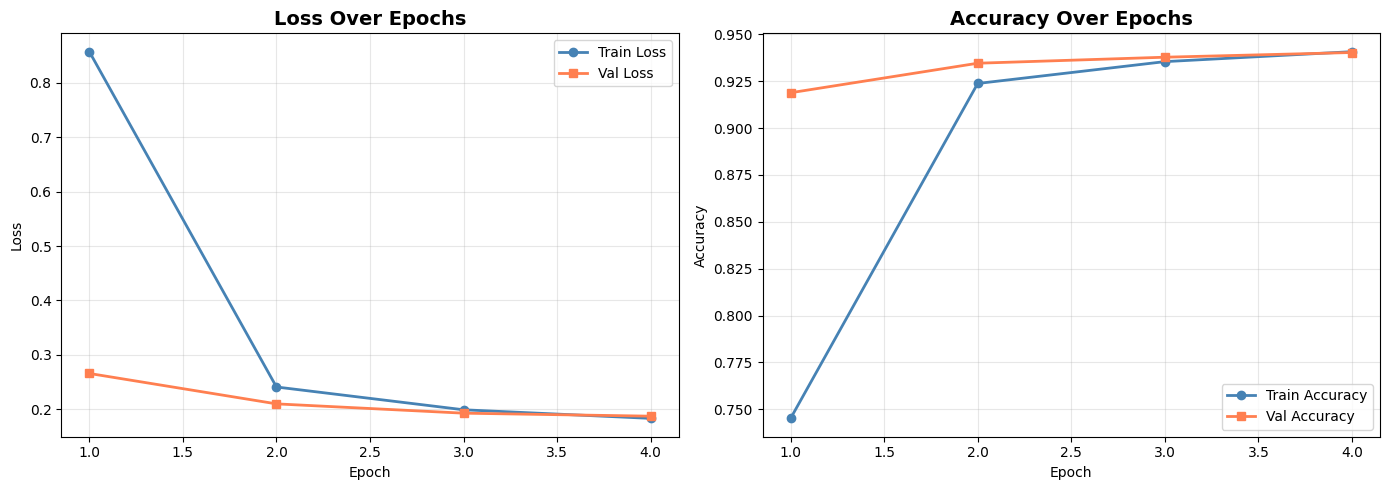

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
epochs_range = range(1, NUM_EPOCHS + 1)

# Loss curve
axes[0].plot(epochs_range, history["train_loss"], "o-", label="Train Loss", color="steelblue", linewidth=2)
axes[0].plot(epochs_range, history["val_loss"], "s-", label="Val Loss", color="coral", linewidth=2)
axes[0].set_title("Loss Over Epochs", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curve
axes[1].plot(epochs_range, history["train_acc"], "o-", label="Train Accuracy", color="steelblue", linewidth=2)
axes[1].plot(epochs_range, history["val_acc"], "s-", label="Val Accuracy", color="coral", linewidth=2)
axes[1].set_title("Accuracy Over Epochs", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Evaluation on Test Set

We evaluate the fine-tuned model on the held-out test set using standard classification metrics.

### 7.1 Generate Predictions

In [20]:
def get_predictions(model, loader, device):
    """Run inference on a DataLoader and collect all predictions and true labels."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)


test_preds, test_labels_arr, test_probs = get_predictions(model, test_loader, DEVICE)
print(f"Predictions collected: {len(test_preds)}")

Predictions collected: 9975


### 7.2 Classification Metrics

We report Accuracy, Precision, Recall, and F1-Score using **weighted** averaging to account for class imbalance.

In [21]:
test_accuracy = accuracy_score(test_labels_arr, test_preds)
test_precision = precision_score(test_labels_arr, test_preds, average="weighted", zero_division=0)
test_recall = recall_score(test_labels_arr, test_preds, average="weighted", zero_division=0)
test_f1 = f1_score(test_labels_arr, test_preds, average="weighted", zero_division=0)

print("=" * 50)
print("Test Set Evaluation Metrics")
print("=" * 50)
print(f"Accuracy:            {test_accuracy:.4f}")
print(f"Precision (weighted): {test_precision:.4f}")
print(f"Recall (weighted):    {test_recall:.4f}")
print(f"F1-Score (weighted):  {test_f1:.4f}")

print(f"\n{'=' * 50}")
print("Per-Class Classification Report")
print("=" * 50)
target_names = [id2label[i] for i in range(num_labels)]
print(classification_report(test_labels_arr, test_preds, target_names=target_names, zero_division=0))

Test Set Evaluation Metrics
Accuracy:            0.9434
Precision (weighted): 0.9437
Recall (weighted):    0.9434
F1-Score (weighted):  0.9435

Per-Class Classification Report
               precision    recall  f1-score   support

      disgust       0.98      0.98      0.98       997
        drive       0.95      0.92      0.94      1000
embarrassment       0.98      0.97      0.98       997
   excitement       0.94      0.94      0.94       995
         fear       0.95      0.96      0.96       998
    happiness       0.95      0.95      0.95       999
   loneliness       0.92      0.91      0.91      1000
         love       0.98      0.97      0.97       998
      sadness       0.87      0.90      0.89       999
     surprise       0.92      0.91      0.91       992

     accuracy                           0.94      9975
    macro avg       0.94      0.94      0.94      9975
 weighted avg       0.94      0.94      0.94      9975



### 7.3 Confusion Matrix

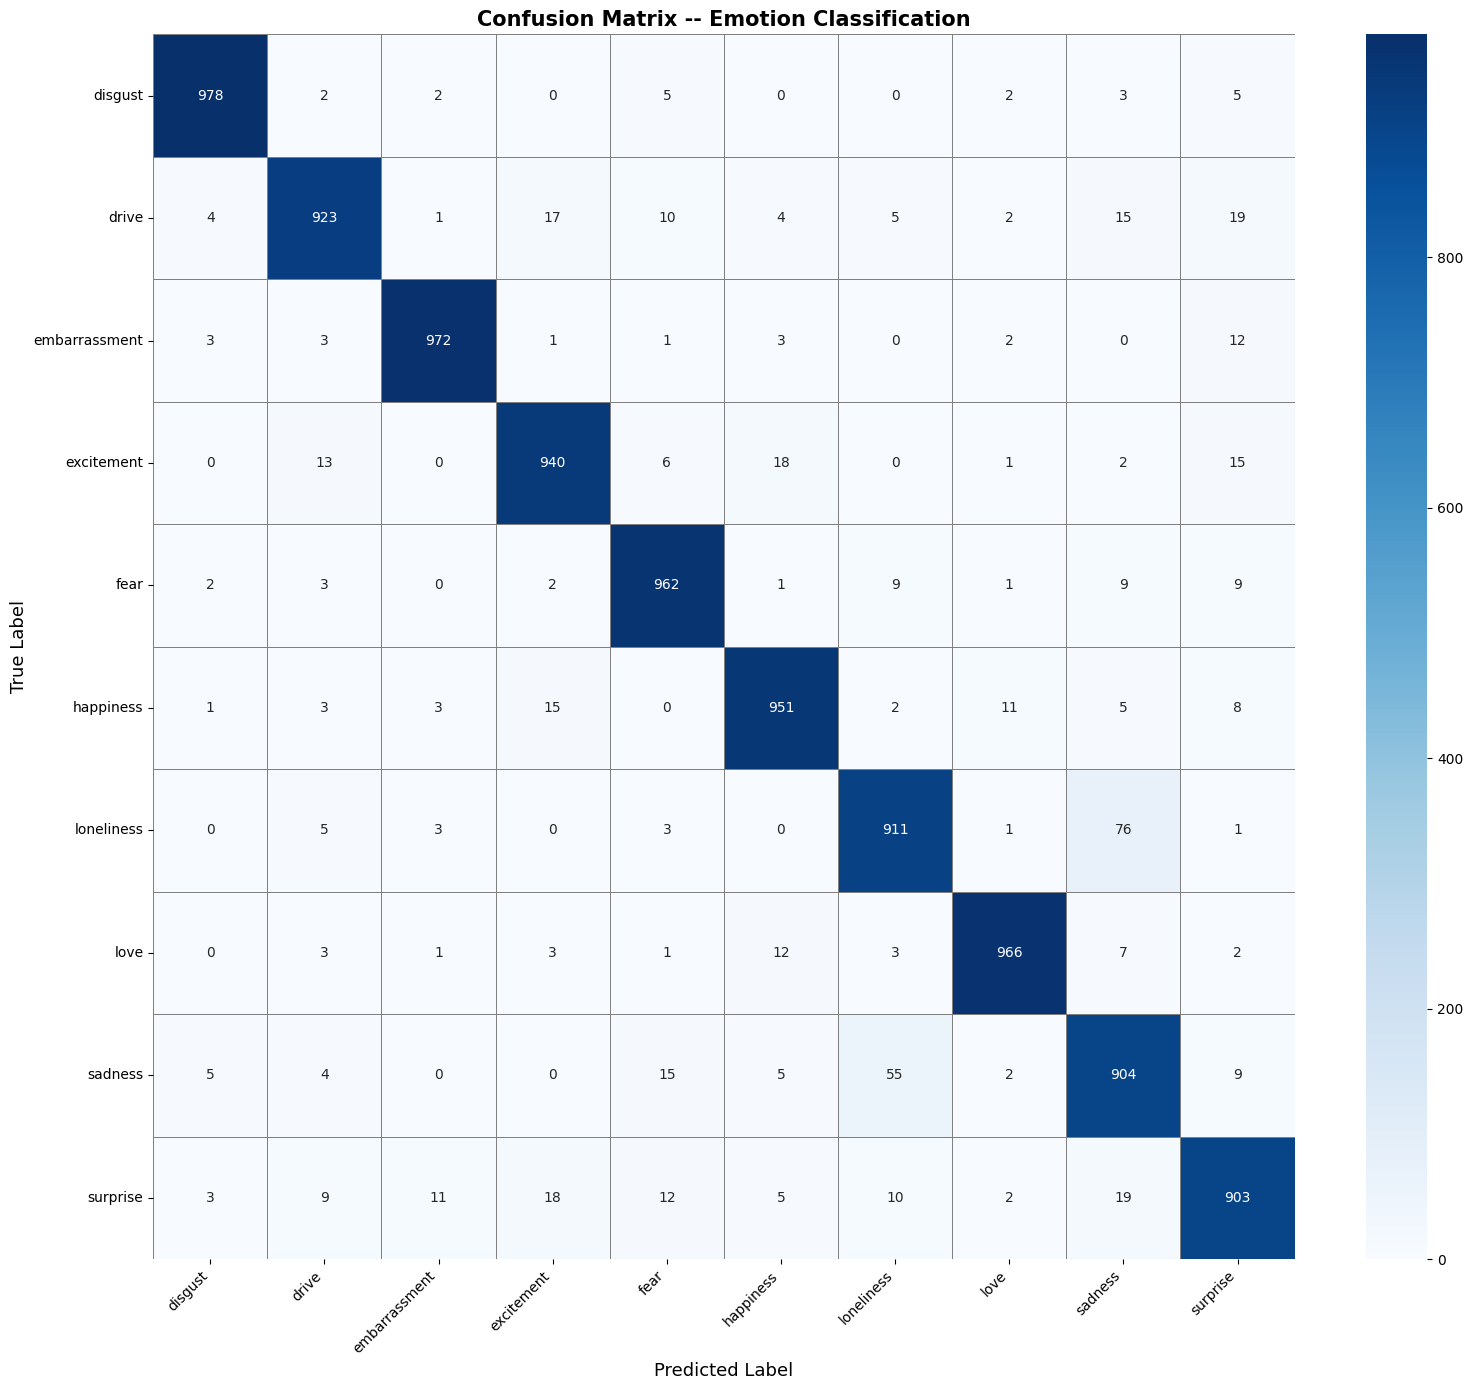

In [22]:
cm = confusion_matrix(test_labels_arr, test_preds)

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names,
    ax=ax,
    linewidths=0.5,
    linecolor="gray",
)
ax.set_xlabel("Predicted Label", fontsize=13)
ax.set_ylabel("True Label", fontsize=13)
ax.set_title("Confusion Matrix -- Emotion Classification", fontsize=15, fontweight="bold")
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

### 7.4 Normalized Confusion Matrix

A row-normalized view makes it easier to see per-class recall and common misclassification patterns.

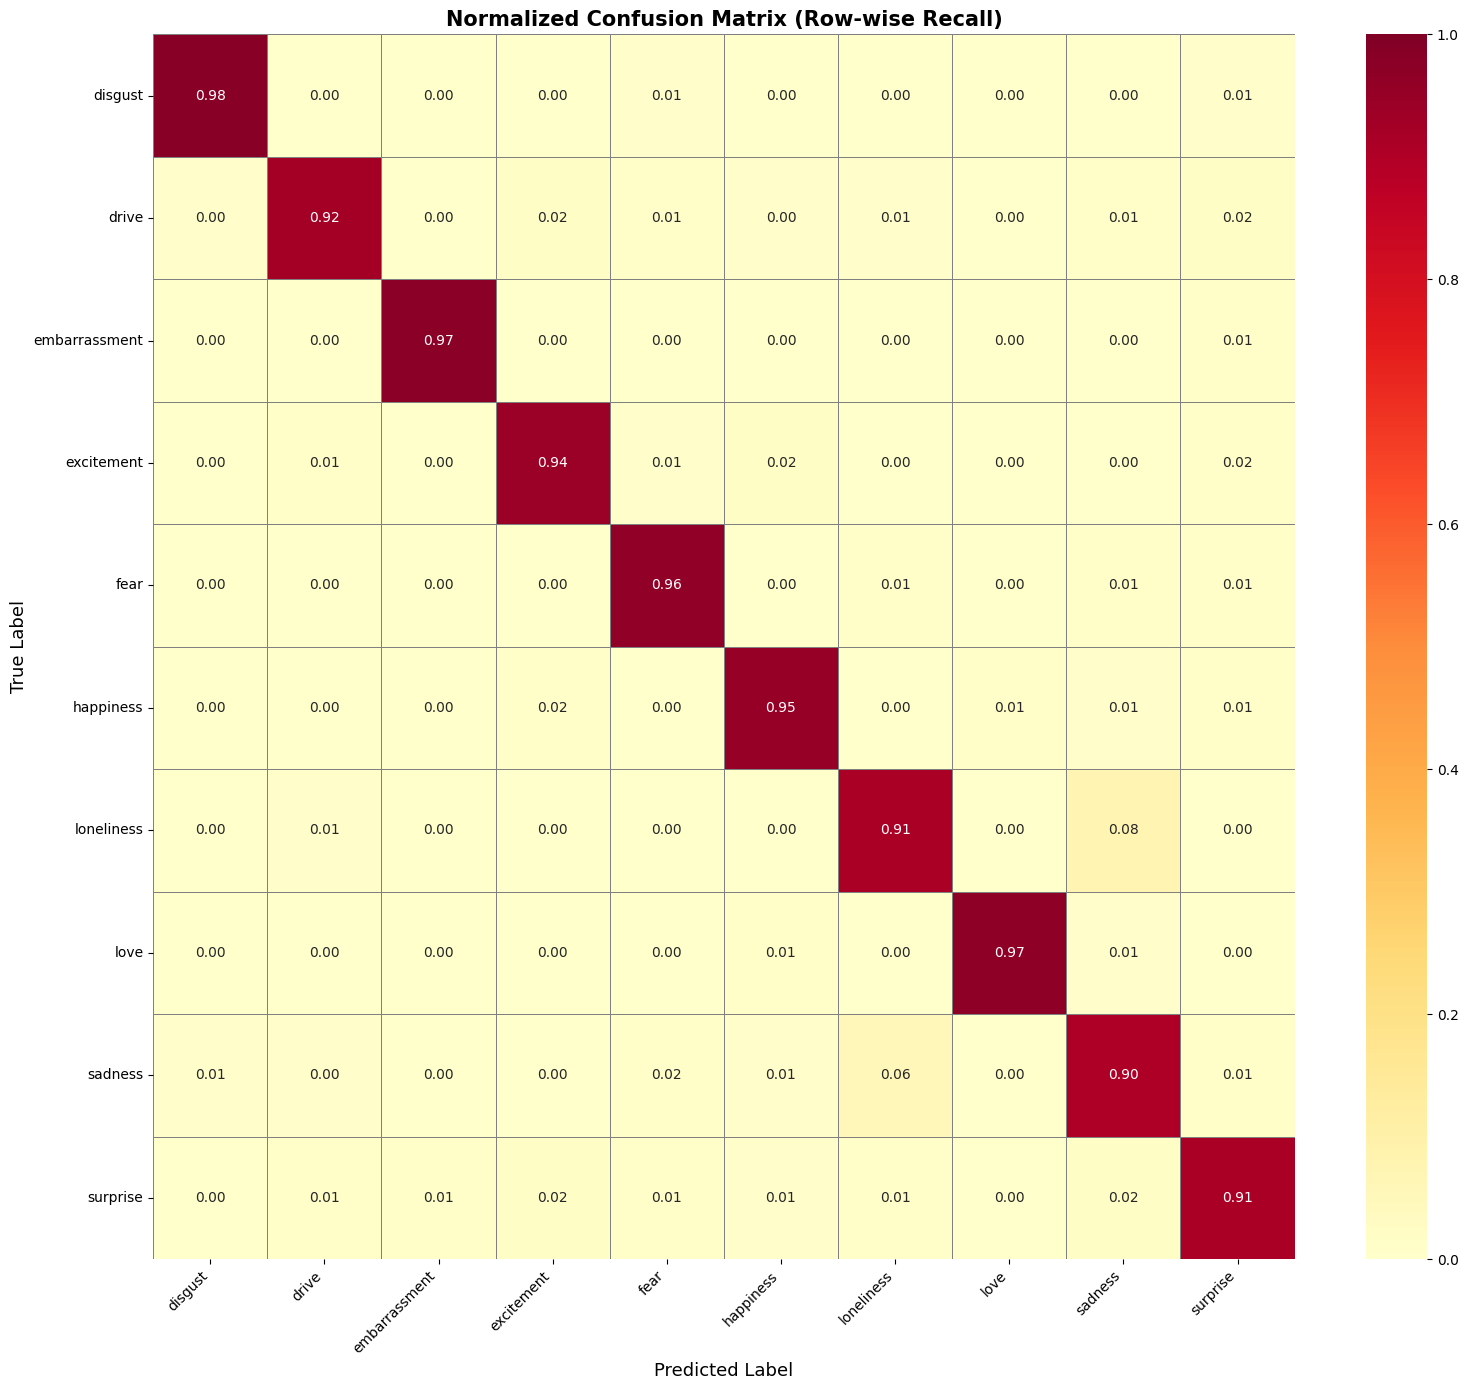

In [23]:
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd",
    xticklabels=target_names,
    yticklabels=target_names,
    ax=ax,
    linewidths=0.5,
    linecolor="gray",
    vmin=0,
    vmax=1,
)
ax.set_xlabel("Predicted Label", fontsize=13)
ax.set_ylabel("True Label", fontsize=13)
ax.set_title("Normalized Confusion Matrix (Row-wise Recall)", fontsize=15, fontweight="bold")
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

## 8. Inference Pipeline

### 8.1 The `predict_text` Function

A simple wrapper that takes a raw text string, tokenizes it using the same head+tail strategy, runs it through the fine-tuned model, and returns the predicted emotion label with a confidence score.

In [24]:
def predict_text(text: str) -> tuple:
    """
    Predict the emotion of a given text string.

    Args:
        text (str): The raw input text.

    Returns:
        tuple: (predicted_label: str, confidence: float)
            - predicted_label: The name of the predicted emotion class.
            - confidence: The softmax probability of the predicted class.
    """
    model.eval()

    # Tokenize with head+tail truncation
    encoding = head_tail_tokenize(text, tokenizer)

    input_ids = torch.tensor([encoding["input_ids"]], dtype=torch.long).to(DEVICE)
    attention_mask = torch.tensor([encoding["attention_mask"]], dtype=torch.long).to(DEVICE)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)

    confidence, predicted_id = torch.max(probs, dim=1)
    predicted_label = id2label[predicted_id.item()]

    return predicted_label, confidence.item()

### 8.2 Testing with Custom Examples

We test the `predict_text` function with 5 diverse examples covering different emotion categories.

In [25]:
custom_examples = [
    "I just got promoted at work and I could not be more thrilled! This is the best day of my life.",
    "I cannot believe they cancelled the event without even telling us. I am so furious right now.",
    "Walking alone in this dark alley at night makes my heart race. Every shadow feels threatening.",
    "I should not have said those hurtful things to my friend. The regret is eating me alive.",
    "I have been sitting here alone for hours. Nobody called, nobody texted. It feels like nobody cares.",
]

print("=" * 70)
print("Inference Pipeline -- Custom Examples")
print("=" * 70)

for i, text in enumerate(custom_examples, 1):
    label, confidence = predict_text(text)
    print(f"\nExample {i}:")
    print(f"  Text:       \"{text}\"")
    print(f"  Predicted:  {label}")
    print(f"  Confidence: {confidence:.4f} ({confidence * 100:.1f}%)")
    print("-" * 70)

Inference Pipeline -- Custom Examples

Example 1:
  Text:       "I just got promoted at work and I could not be more thrilled! This is the best day of my life."
  Predicted:  happiness
  Confidence: 0.9727 (97.3%)
----------------------------------------------------------------------

Example 2:
  Text:       "I cannot believe they cancelled the event without even telling us. I am so furious right now."
  Predicted:  excitement
  Confidence: 0.8055 (80.6%)
----------------------------------------------------------------------

Example 3:
  Text:       "Walking alone in this dark alley at night makes my heart race. Every shadow feels threatening."
  Predicted:  fear
  Confidence: 0.9980 (99.8%)
----------------------------------------------------------------------

Example 4:
  Text:       "I should not have said those hurtful things to my friend. The regret is eating me alive."
  Predicted:  embarrassment
  Confidence: 0.5983 (59.8%)
----------------------------------------------------

### 8.3 Detailed Prediction with Top-K Classes

For a more nuanced view, we can look at the top-5 predictions for each example to understand what emotions the model considers as alternatives.

In [26]:
def predict_text_topk(text: str, k: int = 5) -> list:
    """
    Predict the top-k emotions for a given text.

    Args:
        text (str): The raw input text.
        k (int): Number of top predictions to return.

    Returns:
        list of tuple: [(label, probability), ...] sorted by probability descending.
    """
    model.eval()
    encoding = head_tail_tokenize(text, tokenizer)

    input_ids = torch.tensor([encoding["input_ids"]], dtype=torch.long).to(DEVICE)
    attention_mask = torch.tensor([encoding["attention_mask"]], dtype=torch.long).to(DEVICE)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1).squeeze()

    topk_probs, topk_ids = torch.topk(probs, k)
    results = [(id2label[idx.item()], prob.item()) for idx, prob in zip(topk_ids, topk_probs)]
    return results


print("=" * 70)
print("Top-5 Predictions for Each Custom Example")
print("=" * 70)

for i, text in enumerate(custom_examples, 1):
    top5 = predict_text_topk(text, k=5)
    print(f"\nExample {i}: \"{text[:80]}...\"" if len(text) > 80 else f"\nExample {i}: \"{text}\"")
    for rank, (label, prob) in enumerate(top5, 1):
        bar = "#" * int(prob * 40)
        print(f"  {rank}. {label:<16s} {prob:.4f} {bar}")
    print("-" * 70)

Top-5 Predictions for Each Custom Example

Example 1: "I just got promoted at work and I could not be more thrilled! This is the best d..."
  1. happiness        0.9727 ######################################
  2. excitement       0.0252 #
  3. embarrassment    0.0005 
  4. surprise         0.0004 
  5. fear             0.0004 
----------------------------------------------------------------------

Example 2: "I cannot believe they cancelled the event without even telling us. I am so furio..."
  1. excitement       0.8055 ################################
  2. fear             0.0946 ###
  3. surprise         0.0473 #
  4. drive            0.0290 #
  5. sadness          0.0101 
----------------------------------------------------------------------

Example 3: "Walking alone in this dark alley at night makes my heart race. Every shadow feel..."
  1. fear             0.9980 #######################################
  2. loneliness       0.0008 
  3. excitement       0.0005 
  4. sadness     

## 9. Summary

This notebook implemented an end-to-end pipeline for fine-tuning BERT-uncased on a 20-class emotion detection task:

1. **EDA** revealed the distribution of ~80k samples across 20 emotion classes with moderate class imbalance.
2. **Head+Tail Truncation** was implemented to handle long texts by preserving both the beginning and ending context.
3. **Selective Layer Freezing** (only layer 11 + classifier head trainable) was used to prevent catastrophic forgetting while keeping the training efficient.
4. **Training** was conducted with a low learning rate of 2e-5 using AdamW with linear warmup scheduling.
5. **Evaluation** reported weighted Accuracy, Precision, Recall, and F1-Score alongside a detailed confusion matrix.
6. **Inference Pipeline** provided a `predict_text()` function for real-time emotion classification with confidence scores.